In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv('../creditcard.csv')

# Prepare features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

X_train shape: (227845, 30), X_test shape: (56962, 30)


In [4]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.82      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [5]:
from sklearn.metrics import confusion_matrix

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_xgb

array([[56857,     7],
       [   18,    80]])

In [6]:
%conda install optuna --quiet

3 channel Terms of Service accepted
Channels:
 - defaults
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: c:\fraudDetection\.conda

  added / updated specs:
    - optuna


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    alembic-1.17.2             |  py311haa95532_0         461 KB
    colorama-0.4.6             |  py311haa95532_0          36 KB
    colorlog-6.10.1            |  py311haa95532_0          22 KB
    greenlet-3.2.4             |  py311h885b0b7_0         230 KB
    mako-1.3.10                |  py311haa95532_0         254 KB
    markupsafe-3.0.2           |  py311h827c3e9_0          39 KB
    optuna-4.5.0               |  py311h51baaa3_0         796 KB
    packaging-25.0             |  py311haa95532_1         190 KB
    pyyaml-6.0.3               |  py311hb9a58be_0         233 KB
    sqlalchemy-2.0.43          |  py311hda9a4

In [7]:
import optuna
from sklearn.metrics import f1_score


c:\fraudDetection\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'eval_metric': 'logloss'
    }
    
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)


In [9]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
best_params = study.best_params
best_params


[I 2025-11-30 17:08:53,795] A new study created in memory with name: no-name-596200d7-b4a9-4c9e-a789-3bda31a2b154
[I 2025-11-30 17:09:02,401] Trial 0 finished with value: 0.8709677419354839 and parameters: {'n_estimators': 291, 'max_depth': 6, 'learning_rate': 0.13036625531324672, 'subsample': 0.9896468142471824, 'colsample_bytree': 0.8777879455432595}. Best is trial 0 with value: 0.8709677419354839.
[I 2025-11-30 17:09:02,401] Trial 0 finished with value: 0.8709677419354839 and parameters: {'n_estimators': 291, 'max_depth': 6, 'learning_rate': 0.13036625531324672, 'subsample': 0.9896468142471824, 'colsample_bytree': 0.8777879455432595}. Best is trial 0 with value: 0.8709677419354839.
[I 2025-11-30 17:09:14,419] Trial 1 finished with value: 0.8791208791208791 and parameters: {'n_estimators': 415, 'max_depth': 6, 'learning_rate': 0.04134081077818337, 'subsample': 0.8791684317008464, 'colsample_bytree': 0.6213010304269826}. Best is trial 1 with value: 0.8791208791208791.
[I 2025-11-30 17

{'n_estimators': 435,
 'max_depth': 4,
 'learning_rate': 0.24315866374449863,
 'subsample': 0.6072268466379801,
 'colsample_bytree': 0.9299416091930892}

In [10]:
xgb_best = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    eval_metric='logloss'
)

xgb_best.fit(X_train, y_train)
y_pred_best = xgb_best.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_best))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.84      0.89        98

    accuracy                           1.00     56962
   macro avg       0.98      0.92      0.95     56962
weighted avg       1.00      1.00      1.00     56962



In [11]:
from sklearn.metrics import confusion_matrix

cm_best = confusion_matrix(y_test, y_pred_best)
cm_best


array([[56860,     4],
       [   16,    82]])

In [13]:
%conda install joblib --quiet

3 channel Terms of Service accepted
Channels:
 - defaults
Platform: win-64
Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [20]:
import joblib

joblib.dump(xgb_best, "../models/xgb_best.pkl")
joblib.dump(scaler, "../models/scaler.pkl")


['../models/scaler.pkl']

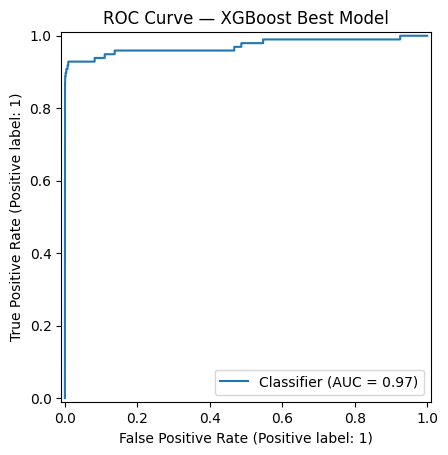

In [23]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

y_prob_best = xgb_best.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob_best)
roc_auc

RocCurveDisplay.from_predictions(y_test, y_prob_best)
plt.title("ROC Curve — XGBoost Best Model")
plt.show()


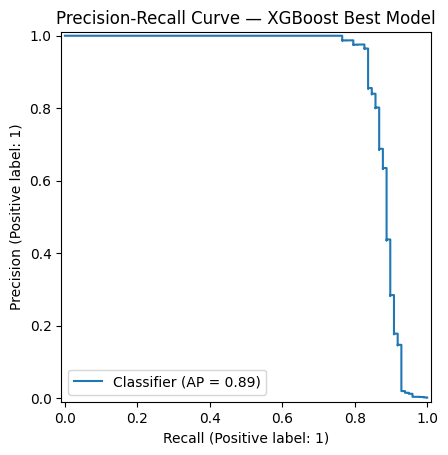

In [24]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(y_test, y_prob_best)
plt.title("Precision-Recall Curve — XGBoost Best Model")
plt.show()
